# This is a notebook for synthesizing data to test calibration

In order to check that `calibrate` is returning a result that makes sense, we are going to:  

1. `sample` a model
2. use that output to generate synthetic data
3. then calibrate the model to that synthetic dataset
4. sanity check that the parameters/results are reasonable compared to the parameters used to create the synthetic data

See [this issue](https://github.com/ciemss/pyciemss/issues/448).

### Load dependencies

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pyciemss
from pyciemss.interfaces import calibrate
import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories

### Collect model and data paths

In [2]:
MODEL_PATH = "https://raw.githubusercontent.com/DARPA-ASKEM/simulation-integration/main/data/models/"
DATA_PATH = "../../docs/source/"

# Models
petri1 = os.path.join(MODEL_PATH, "SEIRHD_with_reinfection01_petrinet.json")
regnet1 = os.path.join(MODEL_PATH, "LV_rabbits_wolves_model02_regnet.json")
stock1 = os.path.join(MODEL_PATH, "SIR_stockflow.json")
stock2 = os.path.join(MODEL_PATH, "SEIRHDS_stockflow.json")

### Set parameters for sampling

In [22]:
start_time = 0.0
end_time = 100.0
logging_step_size = 1.0

### Define functions for generating synthetic data

In [38]:
# Function to add Gaussian noise to `sample` results
def add_gaussian_noise(data: pd.DataFrame, std_dev: float, col_state_map: dict, start_time: float = 0.0, end_time: float = 100.0) -> pd.DataFrame:
    noise = np.random.normal(0, std_dev, size=data.shape)
    noisy_data = data + noise
    noisy_data = noisy_data.abs() # make sure all entries are positive
    noisy_data.insert(0, 'Timestamp', np.arange(start_time + logging_step_size, end_time, logging_step_size).tolist())
    col_state_map = {'Timestamp': 'Timestamp', **col_state_map}
    noisy_data = noisy_data.rename(columns=col_state_map)
    return noisy_data

# Function to sample from a model and generate synthetic data
def get_synthetic_data(model, col_state_map, end_time, logging_step_size, noise_level, start_time):
    num_samples = 1
    result = pyciemss.sample(model_path_or_json=model, end_time=end_time, logging_step_size=logging_step_size, num_samples=num_samples, start_time=start_time)
    data_df = result["data"][list(col_state_map.keys())]
#     print(data_df)
    noisy_data = add_gaussian_noise(data_df, noise_level, col_state_map, start_time=start_time, end_time=end_time)
    noisy_data.to_csv('noisy_data.csv', index=False)
    return noisy_data

# TODO: make_plot=True

## (1) Create synthetic data from a given model

In [39]:
col_state_map = {'I_state': 'Cases', 'H_state': 'Hosp', 'D_state': 'Deaths'}
noise_level = 0.1 # set variance of Gaussian noise
noisy_data = get_synthetic_data(petri1, col_state_map, end_time, logging_step_size, noise_level, start_time)

In [40]:
noisy_data

,Timestamp,Cases,Hosp,Deaths
0,1.0,10.183603,0.038895,0.001880
1,2.0,12.919144,0.231221,0.107988
2,3.0,13.808392,0.187722,0.035279
3,4.0,13.787996,0.061088,0.061089
4,5.0,13.281258,0.000048,0.035633
...,...,...,...,...
94,95.0,0.060288,0.020126,0.009631
95,96.0,0.072593,0.012666,0.030975
96,97.0,0.152381,0.108357,0.085411
97,98.0,0.136546,0.106797,0.225349


## (2) Calibrate the model to the synthetic data

In [41]:
data_mapping = {"Cases": "I", "Hosp": "H", "Deaths": "D"} # data_mapping = "column_name": "observable/state_variable"
num_iterations = 100
dataset = DATA_PATH + "noisy_data.csv"

calibrated_results = calibrate(petri1, dataset, data_mapping=data_mapping, num_iterations=num_iterations)
parameter_estimates = calibrated_results["inferred_parameters"]
calibrated_results

{'inferred_parameters': AutoGuideList(
   (0): AutoDelta()
   (1): AutoLowRankMultivariateNormal()
 ),
 'loss': 10936.065657883883}

In [42]:
parameter_estimates()

{'persistent_beta': tensor(0.1969, grad_fn=<ExpandBackward0>),
 'persistent_gamma': tensor(0.2345, grad_fn=<ExpandBackward0>),
 'persistent_hosp': tensor(0.1053, grad_fn=<ExpandBackward0>),
 'persistent_death_hosp': tensor(0.0538, grad_fn=<ExpandBackward0>),
 'persistent_I0': tensor(7.0352, grad_fn=<ExpandBackward0>)}

In [43]:
num_samples = 10
calibrated_sample_results = pyciemss.sample(petri1, end_time, logging_step_size, num_samples, 
                start_time=start_time, inferred_parameters=parameter_estimates)
display(calibrated_sample_results)

{'data':      timepoint_id  sample_id  persistent_beta_param  persistent_gamma_param  \
 0               0          0               0.175186                0.233132   
 1               1          0               0.175186                0.233132   
 2               2          0               0.175186                0.233132   
 3               3          0               0.175186                0.233132   
 4               4          0               0.175186                0.233132   
 ..            ...        ...                    ...                     ...   
 985            94          9               0.176126                0.234694   
 986            95          9               0.176126                0.234694   
 987            96          9               0.176126                0.234694   
 988            97          9               0.176126                0.234694   
 989            98          9               0.176126                0.234694   
 
      persistent_hosp_param  p

## (3) Plot results of calibration with data

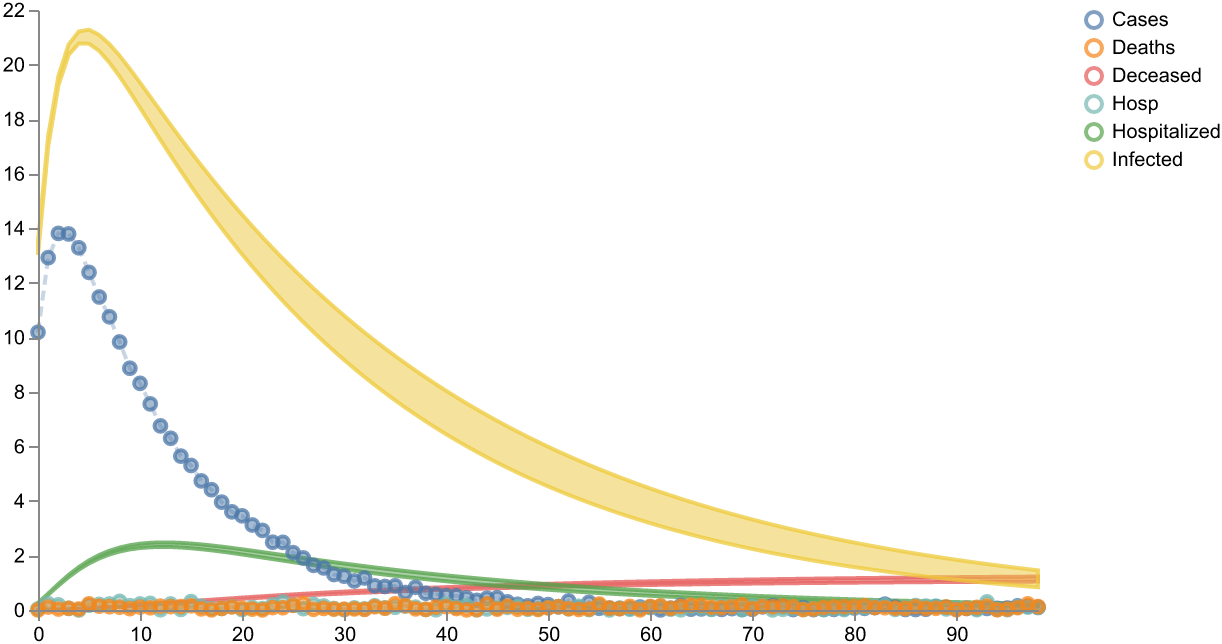

In [44]:
nice_labels={"dead_observable_state": "Deceased", 
             "hospitalized_observable_state": "Hospitalized",
             "infected_observable_state": "Infected"
            }

schema = plots.trajectories(pd.DataFrame(calibrated_sample_results["data"]), 
                           keep=["dead_observable_state", "hospitalized_observable_state", "infected_observable_state"], 
                           relabel=nice_labels,
                           points=noisy_data.drop(columns=['Timestamp']).reset_index(drop=True)
                           )

plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

In [ ]:
# Sanity check: compare calibrated parameters to original